In [1]:
import warnings
warnings.filterwarnings('ignore')

## Importing Libraries and Loading Data

In this section, essential libraries for data manipulation, visualization, and modeling are imported. The dataset is also loaded for further analysis.



In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score,KFold, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


## Data Preprocessing and Visualization Functions

This section includes custom functions for data visualization, outlier detection, handling missing values, normalization, and categorical feature processing. Additionally, it provides functions for plotting ROC curves, confusion matrices, and feature importance.

In [3]:
def print_histo(df, bins):
    """Plot histograms for each numerical feature in the DataFrame."""
    df.hist(bins=bins, figsize=(20, 15))
    plt.show()

def print_box(df):
    """Plot box plots for each numerical feature in the DataFrame."""
    df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(20, 15))
    plt.tight_layout()
    plt.show()

def print_corr_mat(df):
    """Compute and plot the correlation matrix as a heatmap."""
    corr_matrix = df.corr()  # Compute the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

def detect_outliers_z_score(df, columns,toprint=False):
    """Detect outliers using the Z-score method for the specified columns."""
    numeric_df = df[columns].select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(numeric_df))
    outliers = (z_scores > 3).any(axis=1)
    if toprint: print(f"Total amount of outliers in features : {columns} using Z-score method is: {outliers.sum()}")
    return outliers

def detect_outliers_iqr(df, columns,toprint=False):
    """Detect outliers using the IQR method for the specified columns."""
    outlier_indices = set()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))].index
        outlier_indices.update(outliers)
    if toprint: print(f"Total amount of outliers in features : {columns} using IQR method is: {len(list(outlier_indices))}")
    return list(outlier_indices)

def kick_outliers(df,toprint=False):
    """Detect and remove outliers using both Z-score and IQR methods."""
    normal_features = ['A', 'D']  # Assume normal distribution
    non_normal_features = ['B', 'years_of_experience', 'prev_salary']  # Assume non normal distribution

    # Detect outliers using Z-score and IQR methods
    outliers_z_score = detect_outliers_z_score(df, normal_features,toprint)
    outliers_iqr_indices = detect_outliers_iqr(df, non_normal_features,toprint)

    # Combine indices of outliers and remove them from the DataFrame
    outliers_combined = df.index[outliers_z_score | df.index.isin(outliers_iqr_indices)]
    return df.drop(index=outliers_combined)

def fix_null(df, df_test):
    """Handle missing values in the training and test DataFrames."""
    # Fill 'worked_in_the_past' based on 'years_of_experience'
    df.loc[(df['years_of_experience'] > 0) & (df['worked_in_the_past'].isna()), 'worked_in_the_past'] = 'T'
    df.loc[(df['years_of_experience'] == 0) & (df['worked_in_the_past'].isna()), 'worked_in_the_past'] = 'F'
    median_years_of_experience = df['years_of_experience'].median()
    df.loc[(df['worked_in_the_past'] == 'T') & (df['years_of_experience'].isna()), 'years_of_experience'] = median_years_of_experience
    df.loc[(df['worked_in_the_past'] == 'F') & (df['years_of_experience'].isna()), 'years_of_experience'] = 0
    condition = df['worked_in_the_past'].isna() & df['years_of_experience'].isna()
    df.loc[condition, 'years_of_experience'] = 0
    df.loc[condition, 'worked_in_the_past'] = 'F'

    # Fill missing categorical values with 'Other' or mode
    df[['sex', 'education']] = df[['sex', 'education']].fillna({'sex': 'Other', 'education': 'other'})
    for col in ['is_dev', 'disability', 'mental_issues', 'C', 'country', 'age_group']:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)

    # Fill missing numerical values with the median
    num_features = df.select_dtypes(include=[np.number]).columns
    for col in num_features:
        if col not in ['ID', 'years_of_experience', 'label']:
            median = df[col].median()
            df[col] = df[col].fillna(median)
            df_test[col] = df_test[col].fillna(median)

    # Handle missing values in the test DataFrame similarly
    df_test.loc[(df['years_of_experience'] > 0) & (df_test['worked_in_the_past'].isna()), 'worked_in_the_past'] = 'T'
    df_test.loc[(df['years_of_experience'] == 0) & (df_test['worked_in_the_past'].isna()), 'worked_in_the_past'] = 'F'
    df_test.loc[(df_test['worked_in_the_past'] == 'T') & (df_test['years_of_experience'].isna()), 'years_of_experience'] = median_years_of_experience
    df_test.loc[(df_test['worked_in_the_past'] == 'F') & (df_test['years_of_experience'].isna()), 'years_of_experience'] = 0
    condition = df_test['worked_in_the_past'].isna() & df_test['years_of_experience'].isna()
    df_test.loc[condition, 'years_of_experience'] = 0
    df_test.loc[condition, 'worked_in_the_past'] = 'F'

    df_test[['sex', 'education']] = df_test[['sex', 'education']].fillna({'sex': 'Other', 'education': 'other'})
    for col in ['is_dev', 'disability', 'mental_issues', 'C', 'country', 'age_group']:
        mode_value = df[col].mode()[0]
        df_test[col] = df_test[col].fillna(mode_value)

    # Drop the 'label' column from the test DataFrame if it exists
    if 'label' in df_test.columns:
        df_test.drop(columns=['label'], inplace=True)
        
    return df, df_test

def norma_numeric(df, df_test):
    """Normalize numerical features using Min-Max scaling."""
    numerical_features = ['years_of_experience', 'A', 'B', 'D', 'prev_salary']

    # Apply Min-Max scaling to the numerical features
    min_max_scaler = MinMaxScaler()
    df[numerical_features] = min_max_scaler.fit_transform(df[numerical_features])
    df_test[numerical_features] = min_max_scaler.transform(df_test[numerical_features])

    return df, df_test

def handle_catg(df, df_test):
    """Process and encode categorical features in the training and test DataFrames."""
    # Encode binary categorical features
    df['is_dev'] = df['is_dev'].apply(lambda x: 1 if x == 'developer' else 0)
    df['disability'] = df['disability'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Map education levels to numeric values
    education_mapping = {
        'BA/BSc': 2,
        'MA/MSc': 3,
        'Phd': 4,
        'High school': 1,
        'other': 0
    }
    df['education'] = df['education'].replace(education_mapping)
    df['age_group'] = df['age_group'].apply(lambda x: 1 if x == 'young' else 0)
    df['worked_in_the_past'] = df['worked_in_the_past'].apply(lambda x: 1 if x == 'T' else 0)
    df['mental_issues'] = df['mental_issues'].apply(lambda x: 1 if x == 'Yes' else 0)

    # One-hot encode the 'sex' column
    df = pd.get_dummies(df, columns=['sex'], prefix='sex')

    # Process 'stack_experience' feature
    df['stack_experience'] = df['stack_experience'].str.lower()
    skill_count = {}
    for skills in df['stack_experience']:
        if pd.isnull(skills):
            continue
        skills_list = skills.split(';')
        for skill in skills_list:
            skill = skill.strip().lower()
            if skill in skill_count:
                skill_count[skill] += 1
            else:
                skill_count[skill] = 1

    skill_count_df = pd.DataFrame(list(skill_count.items()), columns=['Skill', 'Count'])
    threshold = 500
    filtered_skills = skill_count_df[skill_count_df['Count'] >= threshold]['Skill'].tolist()

    for skill in filtered_skills:
        df[skill] = 0
    for idx, skills in df['stack_experience'].iteritems():
        if pd.isnull(skills):
            continue
        skills_list = skills.split(';')
        for skill in skills_list:
            skill = skill.strip().lower()
            if skill in filtered_skills:
                df.at[idx, skill] = 1
    df.drop(columns=['stack_experience'], inplace=True)

    # Process the test DataFrame similarly
    for skill in filtered_skills:
        df_test[skill] = 0
    for idx, skills in df_test['stack_experience'].iteritems():
        if pd.isnull(skills):
            continue
        skills_list = skills.split(';')
        for skill in skills_list:
            skill = skill.strip().lower()
            if skill in filtered_skills:
                df_test.at[idx, skill] = 1
    df_test['is_dev'] = df_test['is_dev'].apply(lambda x: 1 if x == 'developer' else 0)
    df_test['disability'] = df_test['disability'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_test['education'] = df_test['education'].replace(education_mapping)
    df_test['age_group'] = df_test['age_group'].apply(lambda x: 1 if x == 'young' else 0)
    df_test['worked_in_the_past'] = df_test['worked_in_the_past'].apply(lambda x: 1 if x == 'T' else 0)
    df_test = pd.get_dummies(df_test, columns=['sex'], prefix='sex')
    df_test['mental_issues'] = df_test['mental_issues'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_test.drop(columns=['stack_experience'], inplace=True)

    return df, df_test

def plot_roc_curve(fpr_train, tpr_train, fpr_test, tpr_test, roc_auc_train, roc_auc_test, model):
    """Plot the ROC curve for training and test sets."""
    plt.figure(figsize=(12, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm, title):
    """Plot the confusion matrix."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def importance_feat(model):
    """Plot the feature importance for a given model."""
    feature_importances = model.feature_importances_
    features = X_train.columns

    # Create a DataFrame for the feature importances
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df.head(40))

    # Plot the feature importances
    plt.figure(figsize=(150, 50))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Random Forest Classifier')
    plt.gca()
    plt.show()
    print(importance_df.iloc[60:]['Feature'].tolist())

def plot_roc_curve_kfold(fpr_list, tpr_list, auc_list, model_name, n_folds):
    """Plot the ROC curve for each fold in K-fold cross-validation."""
    plt.figure(figsize=(12, 6))
    for i in range(n_folds):
        plt.plot(fpr_list[i], tpr_list[i], lw=2, 
                 label=f'Fold {i+1} ROC curve (area = {auc_list[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()


# Part 1: Initial Data Exploration


In [4]:
print("Data head:\n")
print(df.head()) # Initial impressions of the data, see column names, and understand the general format.
print("Info:")
print(df.info()) # Number of non-null entries, data types of each column, memory usage.
print("\nData description\n")
print(df.describe(include='all')) # Count, mean, standard deviation, min, max, and percentiles for numerical features, frequency counts for categorical features.


Data head:

      ID worked_in_the_past age_group disability         is_dev education  \
0  65168                  T     young         No      developer       NaN   
1  38314                  T     young         No  non-developer     other   
2   5209                  T       old         No      developer     other   
3  54165                  T     young        NaN      developer     other   
4  42213                  T     young         No      developer    BA/BSc   

    sex mental_issues  years_of_experience          A     B    C           D  \
0  Male            No                 13.0  -1.093080   1.0   aa  180.984266   
1  Male           Yes                  7.0   5.444533   7.0  rhz  180.677533   
2  Male           Yes                 25.0   1.727255  15.0   aa  177.746162   
3  Male            No                 10.0  17.804302   7.0   aa  176.952584   
4  Male            No                 12.0  -8.679091   4.0   hr  179.393259   

                    country  prev_salary  \


In this section, we explore the distribution of numerical data by examining the skewness, spread, and presence of outliers.


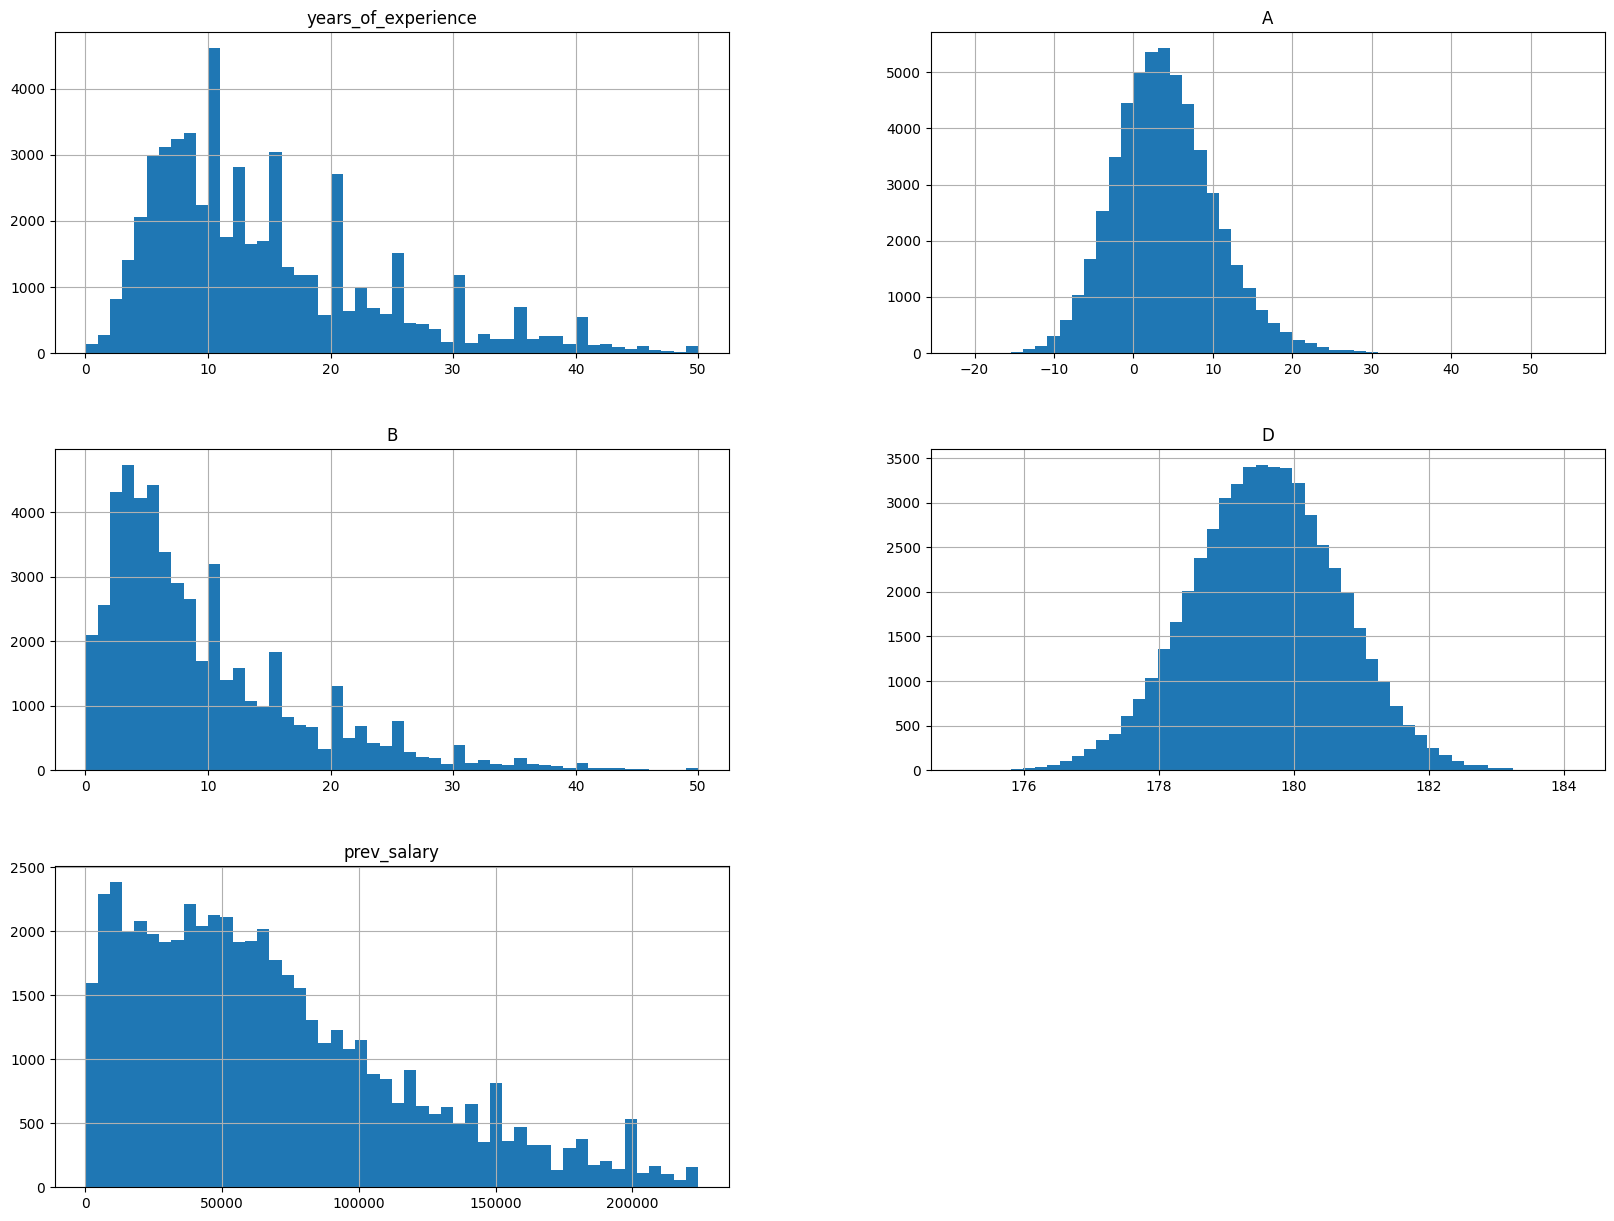

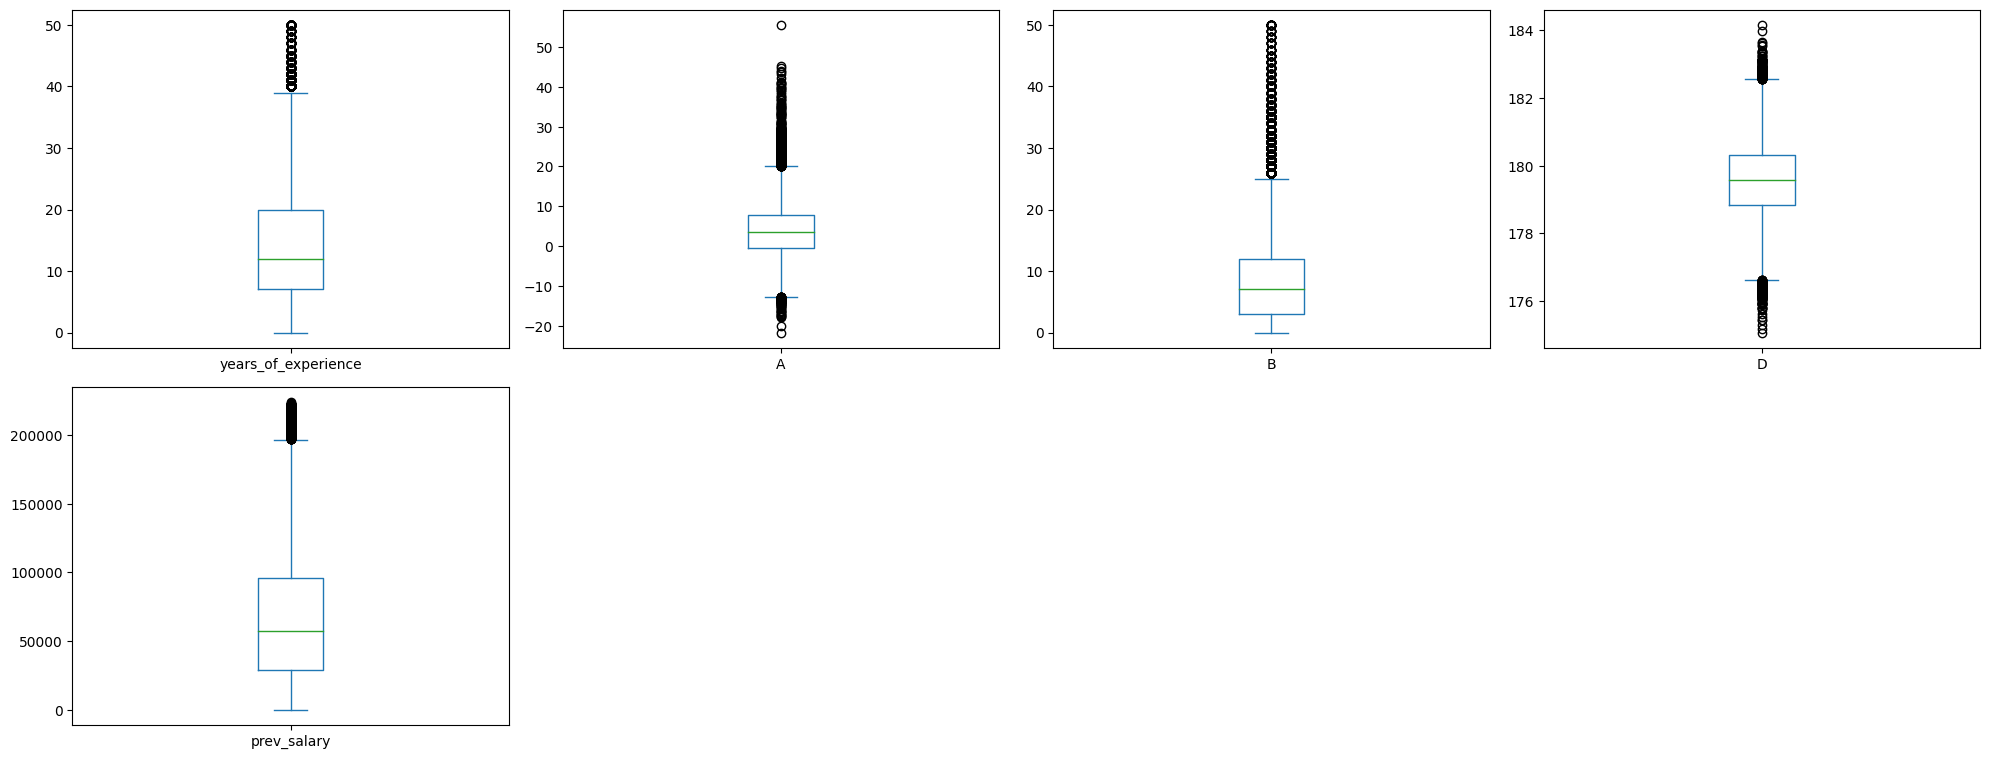

In [5]:
#Learn: Skewness, spread, and the presence of outliers in numerical data.
print_histo(df.drop(columns=['ID','label']),50)
print_box(df.drop(columns=['ID','label']))

#### Conculsion: 
We assume that A and D are normally distributed while B, prev_salary and years_of_expereince aren't.
We can see in the box plots that outliers exist in all features.This indicates that there are values in each feature that significantly deviate from the median.
'D' has a very narrow IQR, indicating that the majority of data points are closely packed within a small range of values.

#### Categorical Data
In this section, we examine the distribution and potential imbalance in categorical data. We will identify common and rare categories for each categorical feature.



In [6]:
# Distribution and imbalance in categorical data, common and rare categories.
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())
    print('\n')

T    47361
F     6336
Name: worked_in_the_past, dtype: int64


young    34545
old      18377
Name: age_group, dtype: int64


No     50281
Yes     1500
Name: disability, dtype: int64


developer        49055
non-developer     4317
Name: is_dev, dtype: int64


BA/BSc         26693
MA/MSc         13503
other           7757
High school     2634
Phd             1859
Name: education, dtype: int64


Male      48777
Female     2490
Other       967
Name: sex, dtype: int64


No     41107
Yes    11940
Name: mental_issues, dtype: int64


aa     21082
ww     10215
hr      7850
rhz     5223
br      4882
mn      2632
ca       576
Name: C, dtype: int64


United States of America                                10690
Germany                                                  3967
India                                                    3891
United Kingdom of Great Britain and Northern Ireland     3462
Canada                                                   1988
                                           

#### Conclusion

The dataset reveals a diverse range of categorical and numerical features, with some significant imbalances. The majority of individuals have worked in the past, are younger, and do not report disabilities. There is a higher proportion of developers compared to non-developers. Numerical features like `years_of_experience` and `prev_salary` vary widely, indicating diverse backgrounds. Some missing values in `education` and `country` will need to be addressed during data cleaning.


#### Unique Values
In this section, we examine the number of unique values in each column to identify potential categorical columns and check for high cardinality features.


In [25]:
print(df.nunique())  # Number of unique values in each column

# Detect potential categorical columns, check for high cardinality features.
# stack experience - large variety of technology skills
# A (53327 unique values), B (51 unique values), C (7 unique values), D (52843 unique values): These columns might represent some numerical measures or derived features. The high number of unique values in A and D suggests continuous or nearly continuous data, while B and C might have more discrete values.

ID                    51837
worked_in_the_past        2
age_group                 2
disability                2
is_dev                    2
                      ...  
vmware                    2
objective-c               2
puppet                    2
chef                      2
lua                       2
Length: 107, dtype: int64


#### Correlation Matrix

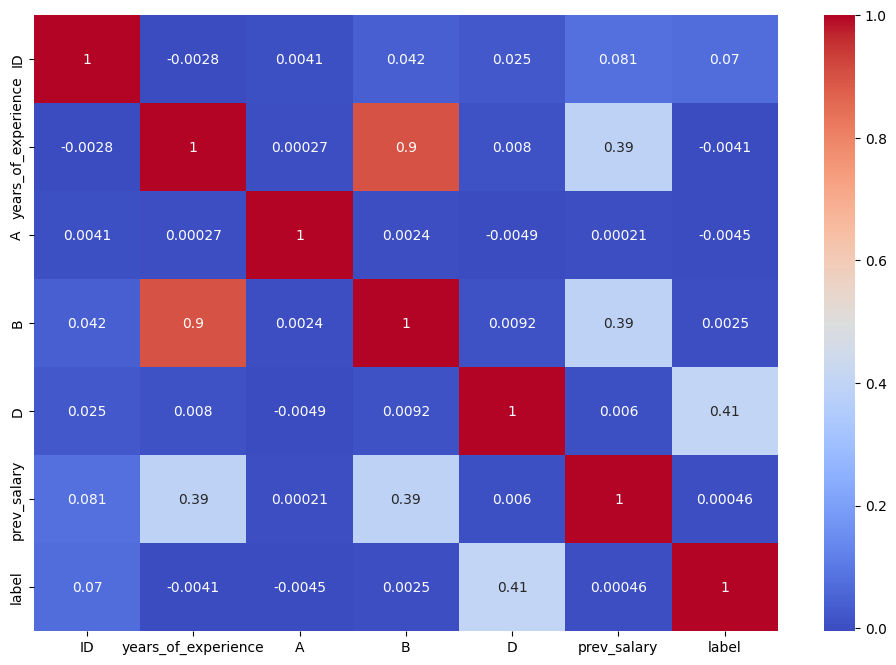

In [8]:
# Quickly identify highly correlated features, potential multicollinearity issues.
print_corr_mat(df)

#### Conclusion:
The correlation heatmap reveals a strong positive correlation (0.9) between 'years_of_experience' and 'B', indicating potential multicollinearity. The feature 'D' shows a moderate positive correlation with the label (0.41), suggesting its importance in prediction. Most other features have weak correlations with each other and the target, implying they offer independent information.

#### Pair Plot
Visualization for the high correlation between B & years_of_experience

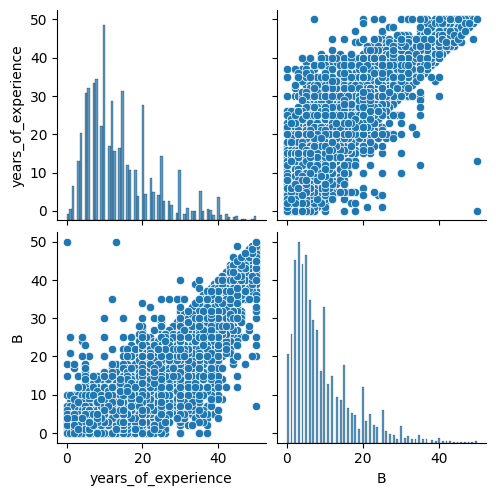

In [9]:
# Pair plot for a subset of features
sns.pairplot(df[['years_of_experience' ,'B']])
plt.show()
#Scatter plots and histograms for feature pairs, understand potential interactions.


# Part 2: Outliers

We assume that A and D are normally distributed while B, prev_salary and years_of_expereince doesn't. Therefore, we will use Z-Score to identify outliers for A and D and IQR for B, prev_salary and years_of_expereince

In [10]:
df = kick_outliers(df,True)

Total amount of outliers in features : ['A', 'D'] using Z-score method is: 0
Total amount of outliers in features : ['B', 'years_of_experience', 'prev_salary'] using IQR method is: 3625


It seems some features might not be normalized like: A, B, C, D,years_of_experience, and prev_salary.
Normalization is particularly important in machine learning because:

Feature Importance: Normalization can make it easier to interpret feature importance when comparing the influence of features on the model.

Data Consistency: Preprocessing the data with normalization, will ensure consistency in data preparation

Improved Performance: For some models, normalization can improve performance and lead to better results because the model doesn't have to deal with large variations in feature scales.

#### Normalize the data using Min-Max Scaler

In [11]:
df,df_test = norma_numeric(df,df_test)

#### Handling missing values

In [12]:
missing_data = df.isnull().sum()
print(missing_data)

df,df_test = fix_null(df,df_test)
print("\nAfter filling:\n")
missing_data = df.isnull().sum()
print(missing_data)

ID                         0
worked_in_the_past      1644
age_group               2372
disability              3442
is_dev                  1928
education               2822
sex                     2995
mental_issues           2243
years_of_experience     2400
A                       1983
B                       3384
C                       2829
D                       2431
country                 1900
prev_salary             2531
stack_experience       13090
label                      0
dtype: int64

After filling:

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                          0
B                          0
C                          0
D                          0
country                    0
prev_salary                0
stack_experience       13090
label        

#### Handling Catagorial Values

In [13]:

df,df_test = handle_catg(df,df_test)


The dataset has 16 features (excluding the label), which is manageable for most algorithms. While high dimensionality isn't a major concern here, further steps like assessing feature importance and applying PCA could optimize the model.

High Dimensionality Issues:

Curse of Dimensionality: Data points become sparse, making pattern detection difficult.
Overfitting: More features can cause models to fit noise rather than true patterns, leading to poor generalization.
Increased Computational Cost: More features require more processing resources.
Data Redundancy: Irrelevant or redundant features can add noise and complexity.
Interpretability: Models with many features are harder to understand and trust.

Evaluating Dimensionality:

Model Performance: Poor validation performance compared to training could indicate overfitting.
Feature Importance: Identifying features with minimal impact can suggest redundancy.
PCA: Determines if a few components explain most of the variance, indicating if the feature space is too large.

## PCA

In [14]:

# Drop specified columns from the DataFrame
feat = df.drop(columns=['label', 'country', 'ID','C'])
print(feat.shape)

# Standardize the features before PCA
scaler = StandardScaler()
X_pca = scaler.fit_transform(feat)

# Apply PCA to retain 99% of the variance
pca_sol = PCA(0.99)
pca_sol.fit(X_pca)

# Get the number of components and the eigenvalues
components = pca_sol.components_
print(len(components))

# Get the eigenvalues
eigenvalues = pca_sol.explained_variance_
total_explained_variance = np.sum(pca_sol.explained_variance_ratio_)
print(f"Total explained variance: {total_explained_variance:.2f}")

# Transform the data using PCA
X_reduced = pd.DataFrame(pca_sol.transform(X_pca))


(51837, 103)
98
Total explained variance: 0.99


In [15]:
# Drop the same columns as in the training set
feat_test = df_test.drop(columns=['country', 'ID', 'C'])
train_columns = feat.columns
feat_test = df_test.reindex(columns=train_columns)
# Scale the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(feat_test)

# Apply the PCA transformation using the PCA fitted on the training data
X_test_pca = pd.DataFrame(pca_sol.transform(X_test_scaled), columns=[f'PC{i+1}' for i in range(len(components))])

# X_test_pca contains the PCA-transformed features of df_test, ensuring consistency with the PCA fitted on the training set (avoiding data leakage).


## Splitting the data to train,validation and test data.

In [16]:
X_train = df.drop(columns=['label','ID','C','B','country','mental_issues','sex_Male','sex_Female','sex_Other','disability','age_group','worked_in_the_past'])

y_train = df['label']
train_and_validation_data,test_data,train_and_validation_labels,test_labels = train_test_split(X_train,y_train,
                                                        test_size = 0.25,
                                                        random_state= 42, 
                                                        shuffle=True,
                                                        stratify = y_train)

# stratify ensures that the training and test sets have the same proportion of each class label as the original dataset
# Splitting the training data further into train and validation sets for hyperparameter tuning and model evaluation
train_data,validation_data ,train_labels,validation_labels = train_test_split(train_and_validation_data,train_and_validation_labels,
                                                        test_size = 0.2,
                                                        random_state= 42, 
                                                        shuffle=True)

# Part 3+4: Model Test Run and Evaluation

## Calculation for optimal C (hyperparameter for logistic regression)

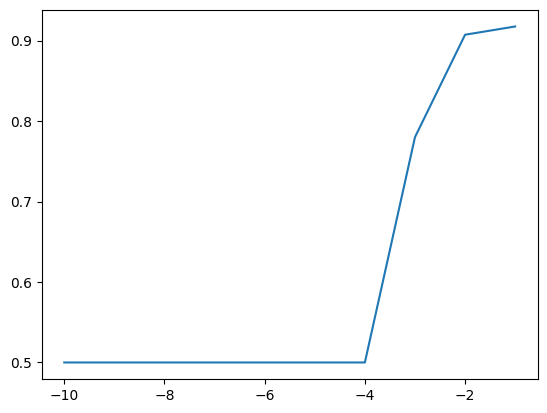

The optimal lambda is: 10.0 
(Best C: 0.1 )


In [17]:
powers = range(-10, 0)
Cs = [10**p for p in powers]
c_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

for c in Cs:
    reg_log = LogisticRegression(penalty="l1", solver="liblinear", random_state=42, C=c)
    
    # Cross-validation score for the current value of C
    scores = cross_val_score(reg_log, train_and_validation_data, train_and_validation_labels, cv=kf, scoring='roc_auc')
    c_scores.append(np.mean(scores))

plt.plot(powers, c_scores)
plt.show()

C_opt_lr = Cs[c_scores.index(max(c_scores))]
lambda_opt_lr = 1 / C_opt_lr

print("The optimal lambda is:", lambda_opt_lr, "\n(Best C:", C_opt_lr, ")")


#### Logistic Regression Model: Training, Evaluation, and Performance Metrics

In this section, we initialize, train and evaluate a Logistic Regression model using the provided training and testing data. The evaluation includes calculating the ROC AUC, plotting ROC curves, and confusion matrices, as well as computing the accuracy for both training and testing data.

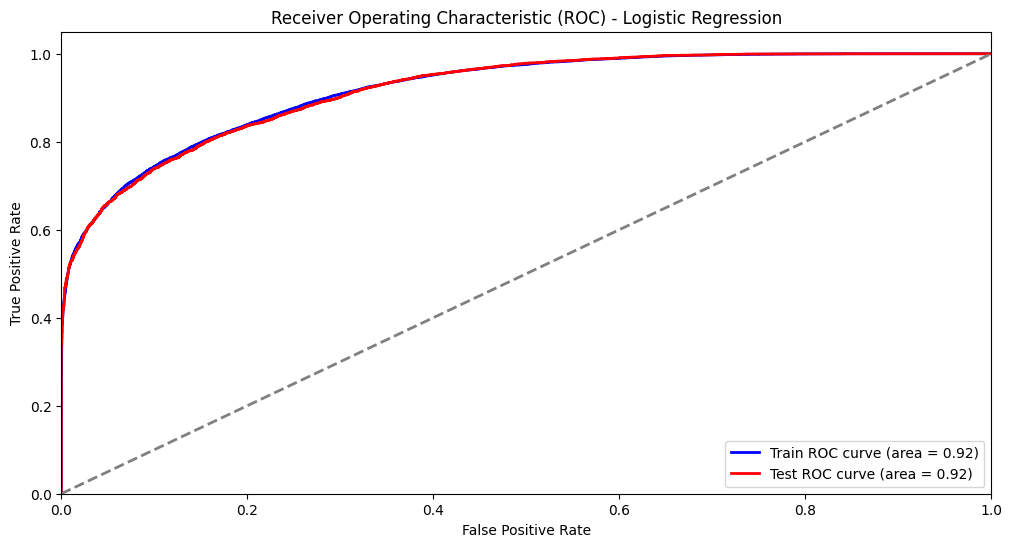

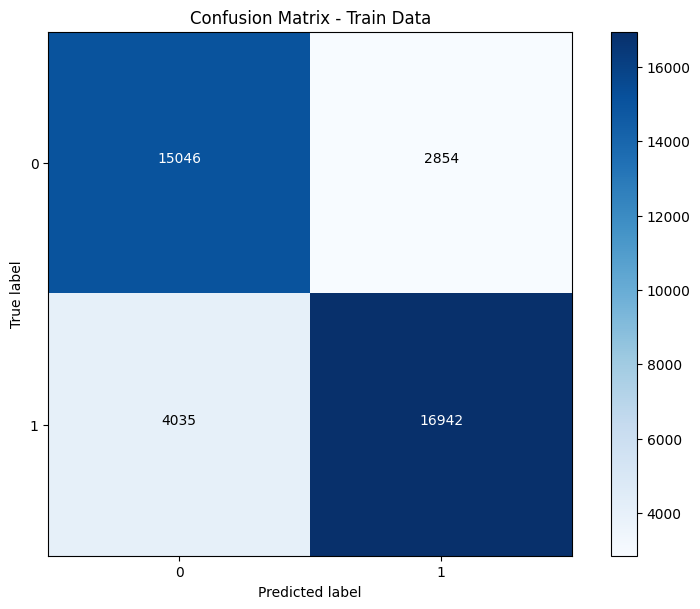

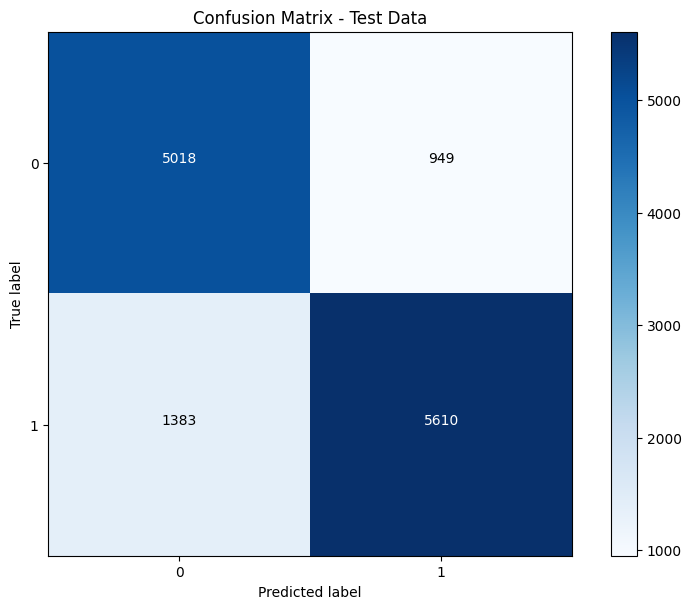

Accuracy on train data: 0.8228
Accuracy on test data: 0.8201
Test confusion Matrix: 
 [[5018  949]
 [1383 5610]]
Test Accuracy: 
 0.8200617283950618
Training AUC: 0.9184
Test AUC: 0.9173


In [18]:


# Initialize and fit Logistic Regression model
log_reg = LogisticRegression(penalty="l1", solver="liblinear", C=C_opt_lr)
log_reg.fit(train_and_validation_data, train_and_validation_labels)

# Predictions and Probabilities
train_probs = log_reg.predict_proba(train_and_validation_data)[:, 1]
test_probs = log_reg.predict_proba(test_data)[:, 1]
train_prediction = log_reg.predict(train_and_validation_data)
test_prediction = log_reg.predict(test_data)

# ROC AUC for training data
fpr_train, tpr_train, _ = roc_curve(train_and_validation_labels, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC AUC for testing data
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plot_roc_curve(fpr_train, tpr_train, fpr_test, tpr_test, roc_auc_train, roc_auc_test,"Logistic Regression")

# Confusion Matrix for Train and Test Data
conf_matrix_train = confusion_matrix(train_and_validation_labels, train_prediction)
conf_matrix_test = confusion_matrix(test_labels, test_prediction)

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Train Data')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Data')

# Accuracy Calculations
accur_train = np.trace(conf_matrix_train) / np.sum(conf_matrix_train)
accur_test = np.trace(conf_matrix_test) / np.sum(conf_matrix_test)
print(f'Accuracy on train data: {accur_train:.4f}')
print(f'Accuracy on test data: {accur_test:.4f}')
print("Test confusion Matrix: \n", conf_matrix_test)
tn, fp, fn, tp = conf_matrix_test.ravel()
print("Test Accuracy: \n", (tp + tn) / conf_matrix_test.sum())

# Print AUC values
print(f'Training AUC: {roc_auc_train:.4f}')
print(f'Test AUC: {roc_auc_test:.4f}')

#### K-Nearest Neighbors (KNN) Model: Training, Evaluation, and Performance Metrics

In this section, we train and evaluate a K-Nearest Neighbors (KNN) classifier using the optimal number of neighbors (`k`) determined from previous cross-validation.

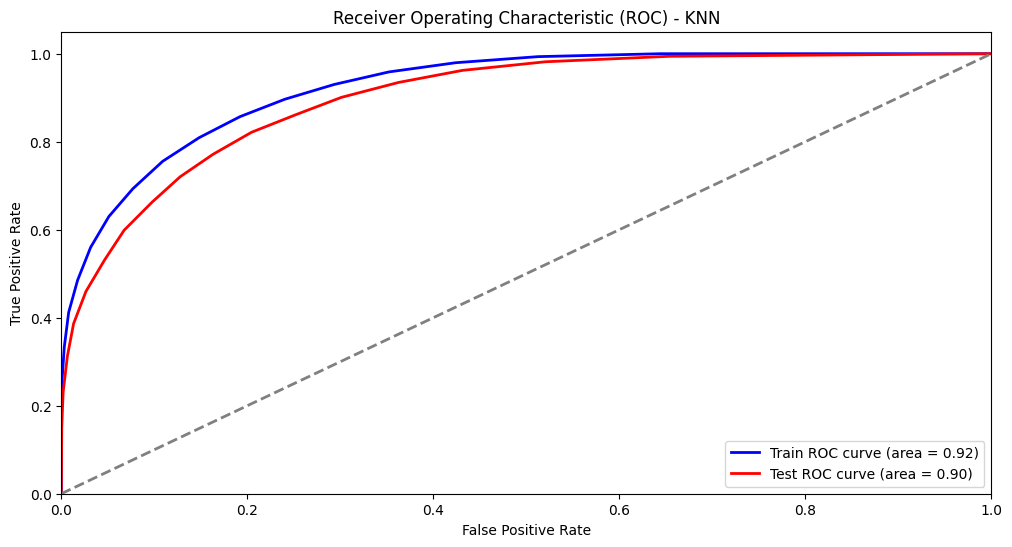

Accuracy on train data: 0.8228


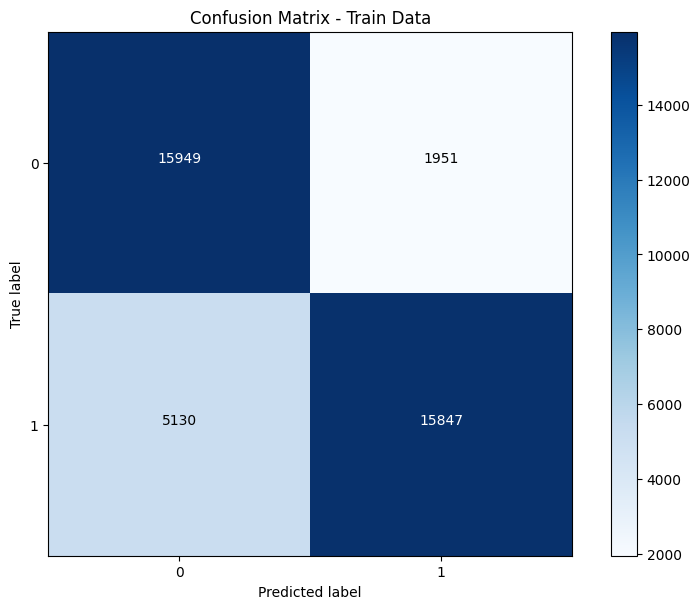

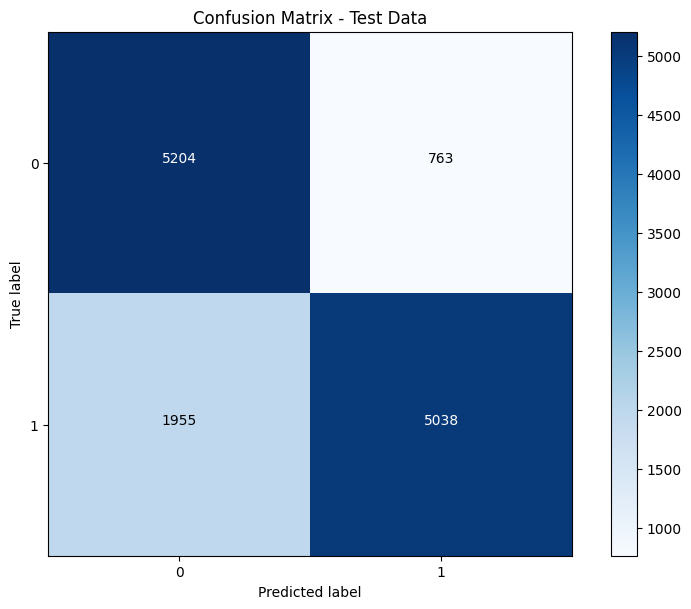

Accuracy on test data: 0.7903
Test confusion Matrix: 
 [[5204  763]
 [1955 5038]]
Test Accuracy: 
 0.7902777777777777
Training AUC: 0.9237
Test AUC: 0.8988


In [19]:

optimal_k=17 # calculated earlier
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(train_and_validation_data, train_and_validation_labels)

# Predictions
train_prediction = knn_model.predict(train_and_validation_data)
test_prediction = knn_model.predict(test_data)

# Probabilities for ROC AUC
train_probs = knn_model.predict_proba(train_and_validation_data)[:, 1]
test_probs = knn_model.predict_proba(test_data)[:, 1]

# ROC AUC for training data
fpr_train, tpr_train, _ = roc_curve(train_and_validation_labels, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC AUC for testing data
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

plot_roc_curve(fpr_train, tpr_train, fpr_test, tpr_test, roc_auc_train, roc_auc_test,"KNN")


# Accuracy on Train Data
accur_train = np.trace(conf_matrix_train) / np.sum(conf_matrix_train)
print(f'Accuracy on train data: {accur_train:.4f}')

# Confusion Matrix for Train and Test Data
conf_matrix_train = confusion_matrix(train_and_validation_labels, train_prediction)
conf_matrix_test = confusion_matrix(test_labels, test_prediction)

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Train Data')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Data')


# Accuracy on Test Data
accur_test = np.trace(conf_matrix_test) / np.sum(conf_matrix_test)
print(f'Accuracy on test data: {accur_test:.4f}')
print("Test confusion Matrix: \n", conf_matrix_test)
tn, fp, fn, tp = conf_matrix_test.ravel()
print("Test Accuracy: \n", (tp + tn) / conf_matrix_test.sum())

# Print AUC values
print(f'Training AUC: {roc_auc_train:.4f}')
print(f'Test AUC: {roc_auc_test:.4f}')



#### Random Forest Model: Hyperparameter Tuning, Training, and Evaluation

In this section, we perform hyperparameter tuning for a Random Forest model using `GridSearchCV`, followed by training and evaluating the model using the best-found parameters.

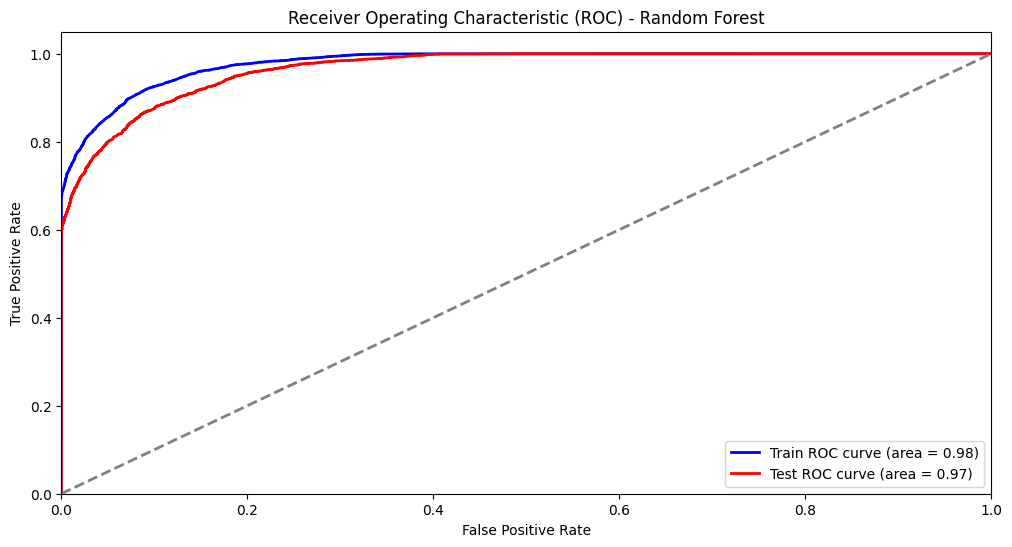

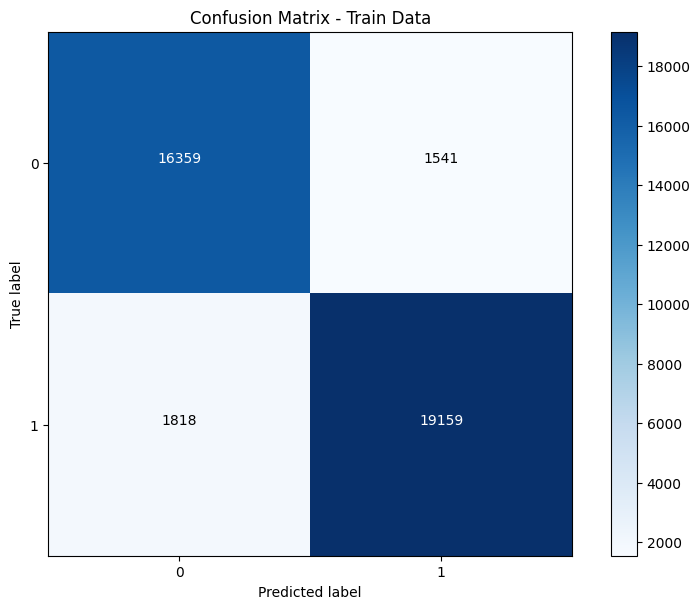

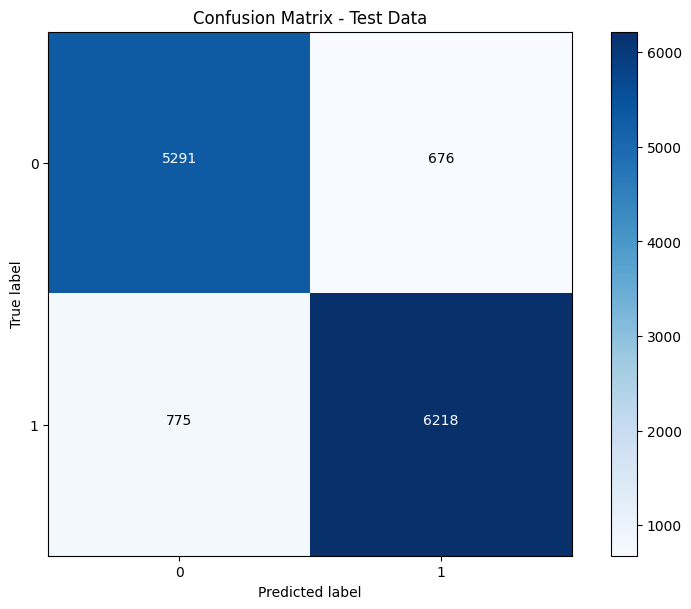

Training AUC: 0.9785
Test AUC: 0.9662


In [20]:


# Best parameters
best_params = {
    'criterion': 'entropy',
    'max_depth': 15,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 150
}

# Initialize the RandomForestClassifier with the best parameters
rf_model = RandomForestClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42 
)

# Train the model
rf_model.fit(train_and_validation_data, train_and_validation_labels)

# Predictions
train_prediction = rf_model.predict(train_and_validation_data)
test_prediction = rf_model.predict(test_data)

# Probabilities for ROC AUC
train_probs = rf_model.predict_proba(train_and_validation_data)[:, 1]
test_probs = rf_model.predict_proba(test_data)[:, 1]

# ROC AUC for training data
fpr_train, tpr_train, _ = roc_curve(train_and_validation_labels, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC AUC for testing data
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

#################


# Plot ROC Curve
plot_roc_curve(fpr_train, tpr_train, fpr_test, tpr_test, roc_auc_train, roc_auc_test,"Random Forest")

# Confusion Matrix for Train and Test Data
conf_matrix_train = confusion_matrix(train_and_validation_labels, train_prediction)
conf_matrix_test = confusion_matrix(test_labels, test_prediction)

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Train Data')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Data')



print(f'Training AUC: {roc_auc_train:.4f}')
print(f'Test AUC: {roc_auc_test:.4f}')


   

#importance_feat(rf_model)


#### AdaBoost Model: Hyperparameter Setup, Training, Evaluation, and Validation

In this section, we define the best hyperparameters for an AdaBoost model, initialize the model, and evaluate its performance. Additionally, we validate the model using cross-validation and learning curves to check for overfitting.


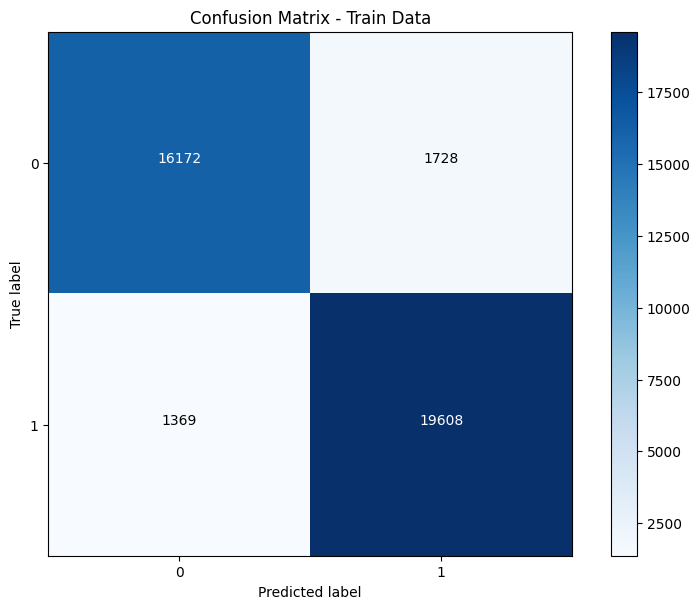

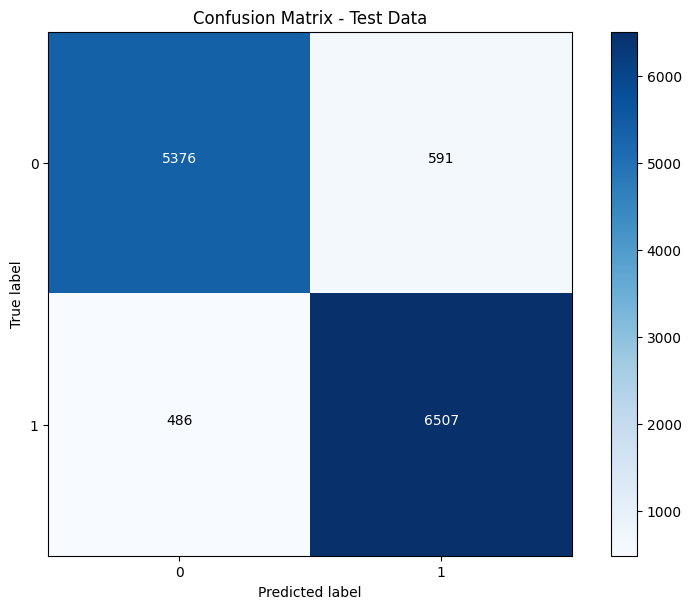

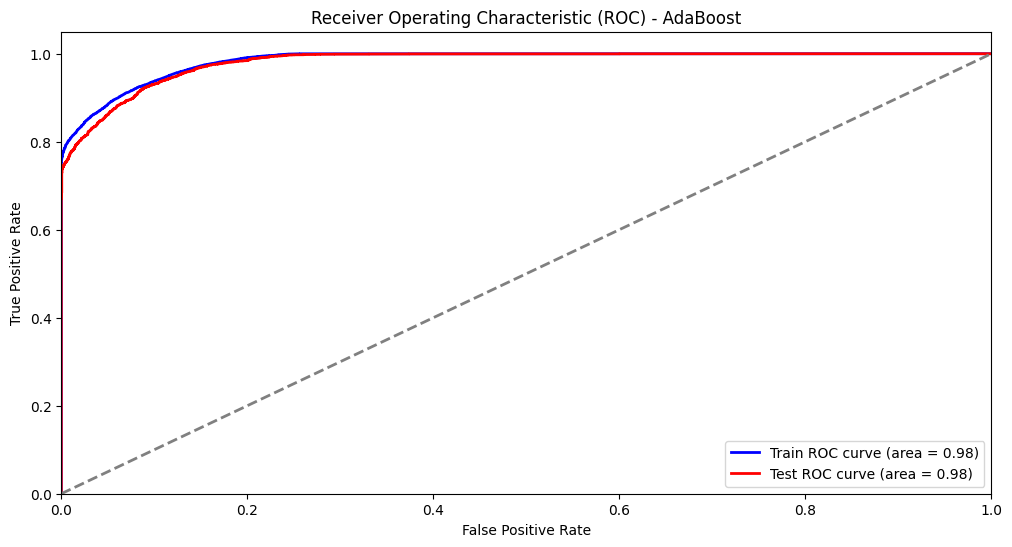

Training AUC: 0.9843
Test AUC: 0.9811


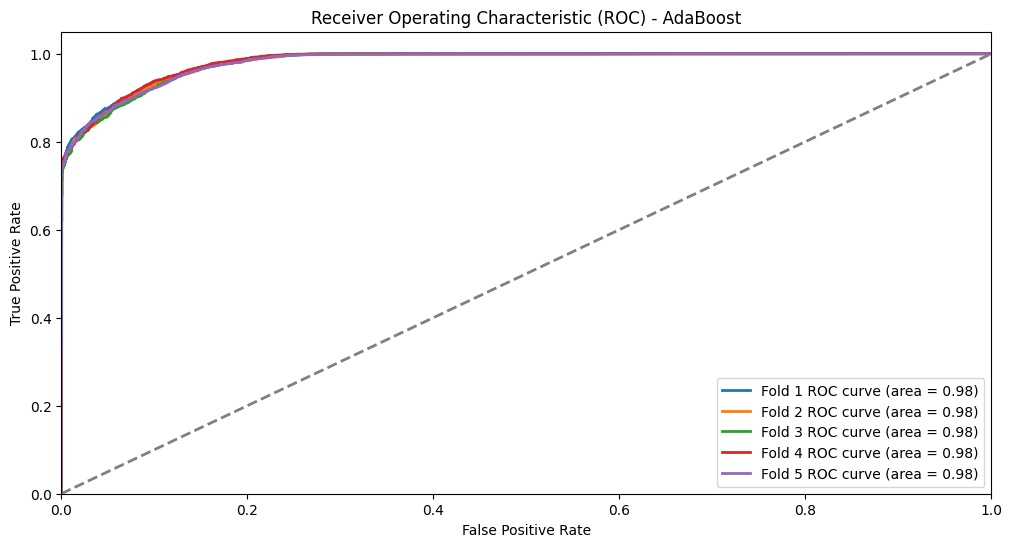

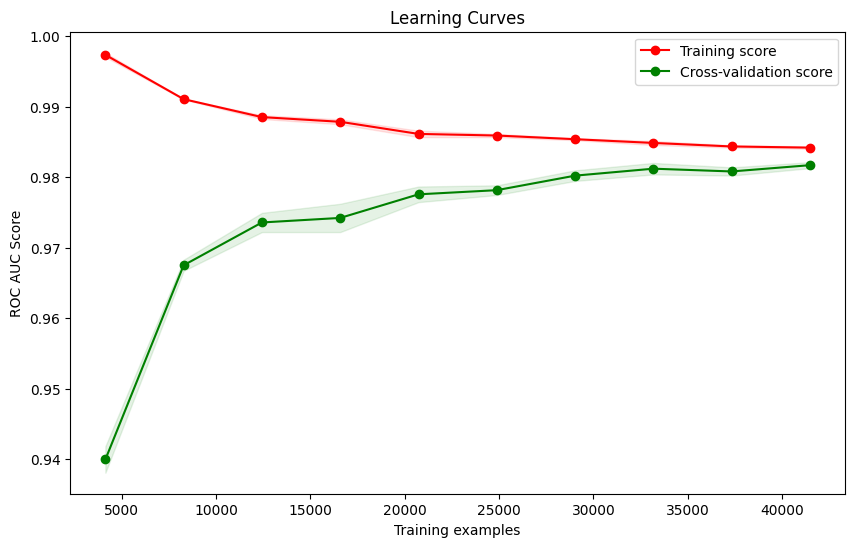

The model does not appear to be overfitting.


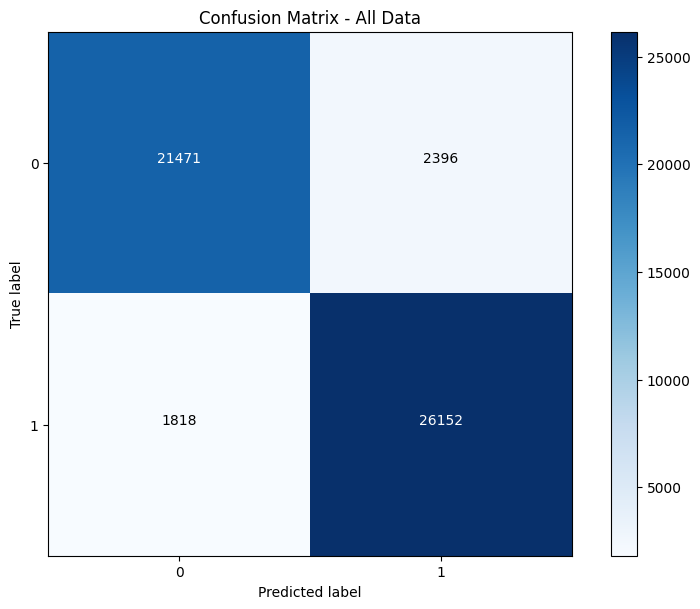

X AUC: 0.9836


In [21]:

best_params = {
    'base_estimator__ccp_alpha': 0.0,
    'base_estimator__class_weight': None,
    'base_estimator__criterion': 'gini',
    'base_estimator__max_depth': 2,
    'base_estimator__max_features': None,
    'base_estimator__max_leaf_nodes': None,
    'base_estimator__min_impurity_decrease': 0.0,
    'base_estimator__min_samples_leaf': 3,
    'base_estimator__min_samples_split': 2,
    'base_estimator__min_weight_fraction_leaf': 0.0,
    'base_estimator__random_state': 42,
    'base_estimator__splitter': 'best',
    'n_estimators': 200,  
    'random_state': 42  # This is typically kept for reproducibility
}

# Initialize the base estimator
base_estimator = DecisionTreeClassifier(
    max_depth=best_params['base_estimator__max_depth'],
    min_samples_leaf=best_params['base_estimator__min_samples_leaf'],
    min_samples_split=best_params['base_estimator__min_samples_split'],
    random_state=best_params['base_estimator__random_state']
)

# Initialize AdaBoost classifier with optimized parameters obtained from GridSearchCV
ada_clf = AdaBoostClassifier(
    base_estimator=base_estimator,
    n_estimators=best_params['n_estimators'],
    random_state=best_params['random_state']
)


# Fit the model (assuming train_and_validation_data and train_and_validation_labels are defined)
ada_clf.fit(train_and_validation_data, train_and_validation_labels)

# Predictions
train_prediction = ada_clf.predict(train_and_validation_data)
train_probs = ada_clf.predict_proba(train_and_validation_data)[:, 1]

# Make predictions on the test set (assuming test_data and test_labels are defined)
test_pred = ada_clf.predict(test_data)
test_prob = ada_clf.predict_proba(test_data)[:, 1]

# Confusion Matrices
conf_matrix_train = confusion_matrix(train_and_validation_labels, train_prediction)
conf_matrix_test = confusion_matrix(test_labels, test_pred)

# Plot Confusion Matrices

plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Train Data')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Data')

# ROC AUC for test data
fpr_test, tpr_test, _ = roc_curve(test_labels, test_prob)
roc_auc_test = roc_auc_score(test_labels, test_prob)

# ROC AUC for training data
fpr_train, tpr_train, _ = roc_curve(train_and_validation_labels, train_probs)
roc_auc_train = roc_auc_score(train_and_validation_labels, train_probs)

plot_roc_curve(fpr_train, tpr_train, fpr_test, tpr_test, roc_auc_train, roc_auc_test,"AdaBoost")

print(f'Training AUC: {roc_auc_train:.4f}')
print(f'Test AUC: {roc_auc_test:.4f}')

# Define the number of folds
n_folds = 5


# Lists to store fpr, tpr, and auc values for each fold
fpr_list = []
tpr_list = []
auc_list = []

# Initialize KFold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation and plot ROC curves for each fold
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    ada_clf.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities for the validation fold
    val_probs = ada_clf.predict_proba(X_val_fold)[:, 1]
    
    # Calculate ROC curve and AUC for the validation fold
    fpr, tpr, _ = roc_curve(y_val_fold, val_probs)
    roc_auc = auc(fpr, tpr)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)


# Plot ROC curve for each fold
plot_roc_curve_kfold(fpr_list, tpr_list, auc_list, "AdaBoost", n_folds)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    ada_clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Adding fill between for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Check for overfitting
if train_scores_mean[-1] - test_scores_mean[-1] > 0.1:  # Adjust the threshold as necessary
    print("The model is likely overfitting. The training score is much higher than the cross-validation score.")
else:
    print("The model does not appear to be overfitting.")

# Refit model on entire training data
ada_clf.fit(X_train, y_train)

# Predictions and ROC AUC for full training set
X_probs = ada_clf.predict_proba(X_train)[:, 1]
fpr_X, tpr_X, _ = roc_curve(y_train, X_probs)
roc_auc_full_train = roc_auc_score(y_train, X_probs)

# Predictions
X_prediction = ada_clf.predict(X_train)

# Confusion Matrices
conf_matrix_X = confusion_matrix(y_train, X_prediction)

# Plot Confusion Matrices
plot_confusion_matrix(conf_matrix_X, 'Confusion Matrix - All Data')

# ROC AUC for test data
fpr_X, tpr_X, _ = roc_curve(y_train, X_probs)

print(f'X AUC: {roc_auc_full_train:.4f}')




# Part 5: Prediction
## End-to-End Machine Learning Pipeline for AdaBoost Model
*The libraries and the function cell must be loaded before*

This section implements an end-to-end machine learning pipeline that includes data preprocessing, model training, and prediction generation using an AdaBoost classifier with a `DecisionTreeClassifier` as the base estimator. The pipeline processes both training and test datasets, trains the model, and produces prediction probabilities for the test data.



In [22]:
def pipeline():
    df = pd.read_csv("train.csv")
    df_test=pd.read_csv("test.csv")
    df = kick_outliers(df)
    df,df_test = norma_numeric(df,df_test)    
    df,df_test = fix_null(df,df_test)
    df,df_test = handle_catg(df,df_test)
    X_train = df.drop(columns=['label','ID','C','B','country','mental_issues','sex_Male','sex_Female','sex_Other','disability','age_group','worked_in_the_past'])
    y_train = df['label']


    best_params = {
        'base_estimator__ccp_alpha': 0.0,
        'base_estimator__class_weight': None,
        'base_estimator__criterion': 'gini',
        'base_estimator__max_depth': 2,
        'base_estimator__max_features': None,
        'base_estimator__max_leaf_nodes': None,
        'base_estimator__min_impurity_decrease': 0.0,
        'base_estimator__min_samples_leaf': 3,
        'base_estimator__min_samples_split': 2,
        'base_estimator__min_weight_fraction_leaf': 0.0,
        'base_estimator__random_state': 42,
        'base_estimator__splitter': 'best',
        'n_estimators': 200,  
        'random_state': 42  
    }

    # Initialize the base estimator
    base_estimator = DecisionTreeClassifier(
        max_depth=best_params['base_estimator__max_depth'],
        min_samples_leaf=best_params['base_estimator__min_samples_leaf'],
        min_samples_split=best_params['base_estimator__min_samples_split'],
        random_state=best_params['base_estimator__random_state']
    )

    # Initialize AdaBoost classifier with simplified parameters
    ada_clf = AdaBoostClassifier(
        base_estimator=base_estimator,
        n_estimators=best_params['n_estimators'],
        random_state=best_params['random_state']
    )

    # Fit model on entire training data
    ada_clf.fit(X_train, y_train)

    id_column = (pd.read_csv("test.csv"))['ID']
    df_test.drop(columns=['ID','C','B','country','mental_issues','sex_Male','sex_Female','sex_Other','disability','age_group','worked_in_the_past'],inplace=True)
    train_columns = X_train.columns
    df_test = df_test.reindex(columns=train_columns)
    # Get the prediction probabilities

    final_test_pred_proba = ada_clf.predict_proba(df_test)[:, 1] 

    output_df = pd.DataFrame({
        'ID': id_column,
        'predict_proba': final_test_pred_proba
    })

    # Save the predicted probabilities to a CSV file for further analysis or submission
    output_df.to_csv('results_9.csv', index=False)



pipeline()

